OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.



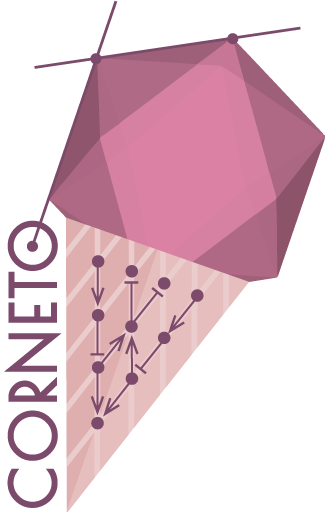

In [1]:
import pandas as pd
import cptac as cp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import decoupler as dc
import corneto as cn
from corneto.graph import Graph
from corneto.data import Data
from corneto.methods.future.carnival import CarnivalFlow, CarnivalILP
from corneto.contrib.networkx import corneto_graph_to_networkx
from corneto.methods.signalling.carnival import multi_carnival
cn.info()

In [2]:
# load prior knowledge: Biological entities of interest (receptors, kinases, TFs), and regulons for TF and Kinase activity analysis
receptors = pd.read_csv('https://raw.githubusercontent.com/saezlab/liana-py/refs/heads/main/liana/resource/omni_resource.csv')
receptors = set(receptors[receptors['resource'] == 'consensus']['target_genesymbol'])
kinases = set(pd.read_csv('https://raw.githubusercontent.com/esbgkannan/phosformer/refs/heads/main/data/reference_human_kinases.csv').gene)
collectri = pd.read_csv('https://zenodo.org/records/8192729/files/CollecTRI_regulons.csv')
tfs = set(collectri.source)
all_genes = receptors.union(kinases).union(tfs)

# load phospho regulons
psiteplus = pd.read_csv('https://omnipathdb.org/enz_sub?genesymbols=1', sep = '\t')
psiteplus_todc = psiteplus[psiteplus['modification'] == 'phosphorylation'].copy()
psiteplus_todc = psiteplus_todc[['enzyme_genesymbol', 'substrate_genesymbol', 'residue_type','residue_offset']]
psiteplus_todc = psiteplus_todc[~psiteplus_todc['substrate_genesymbol'].isin(tfs)]
psiteplus_todc['target'] = psiteplus_todc['substrate_genesymbol'] + '_' + psiteplus_todc['residue_type'] + psiteplus_todc['residue_offset'].astype(str)
psiteplus_todc = psiteplus_todc[['enzyme_genesymbol', 'target']].rename(columns = {'enzyme_genesymbol':'source'}).drop_duplicates()
psiteplus_todc['weight'] = 1

# load signaling PPI network
omnipath = pd.read_csv('https://omnipathdb.org/interactions/?genesymbols=1', sep='\t')
omnipath = omnipath[omnipath['is_directed'] == 1]
omnipath['sign'] = np.where(omnipath['consensus_stimulation'] == 1, 1, np.where(omnipath['consensus_inhibition'] == 1, -1, 0))
omnipath = omnipath[omnipath['sign'] != 0]
omnipath = omnipath[omnipath['source_genesymbol'] != omnipath['target_genesymbol']]
omnipath = omnipath[['source_genesymbol', 'target_genesymbol', 'sign']].rename(columns={'source_genesymbol': 'source', 'target_genesymbol': 'target'})
omnipath

,source,target,sign
0,CALM1,TRPC1,-1
1,CALM3,TRPC1,-1
2,CALM2,TRPC1,-1
3,CAV1,TRPC1,1
4,DRD2,TRPC1,1
...,...,...,...
81463,SYK,NFKBIA,1
81476,MAPK3,GATA4,1
81487,GRK5,CXCR4,1
81488,SLK,RHOA,-1


In [3]:
# load and compute per patient differential profiles using the LUAD cptac dataset
lu = cp.Luad()
print(lu.list_data_sources())
som_muts = lu.get_somatic_mutation('harmonized')
transcriptomics = lu.get_transcriptomics('bcm')
pp = lu.get_phosphoproteomics('umich')

def compute_diff(input_df):
    sample_list = list(input_df.columns)
    normal_samples = {s[:-2]: s for s in sample_list if s.endswith('.N')}
    tumor_samples = [s for s in sample_list if not s.endswith('.N')]
    tumor_to_normal = {tumor: normal_samples[tumor] for tumor in tumor_samples if tumor in normal_samples}
    print("Tumor to Normal Matches:", len(tumor_to_normal))
    print("Unmatched Tumor Samples:", len(tumor_samples) - len(tumor_to_normal))

    # for each patient, compute difference between tumor and normal
    diffs = []
    for tumor, normal in tumor_to_normal.items():
        diff = input_df[tumor] / input_df[normal]
        diffs.append(diff)

    diff_df = pd.concat(diffs, axis=1)
    diff_df.columns = tumor_to_normal.keys()

    # set infs, 0s, and nans to np.nan
    diff_df = diff_df.replace([np.inf, -np.inf], np.nan)
    diff_df = diff_df.replace(0, np.nan)
    diff_df = diff_df.replace(np.nan, np.nan)
    diff_df = np.log2(diff_df)

    return diff_df
rna_diff = compute_diff(transcriptomics.T)
rna_diff = rna_diff.groupby(level=0).mean()
pp_diff = compute_diff(pp.T)
pp_diff = pp_diff.groupby(level=[0, 1]).mean()
pp_diff.index = pp_diff.index.map('_'.join)

              Data type    Available sources
0                   CNV         [bcm, washu]
1          circular_RNA                [bcm]
2                 miRNA         [bcm, washu]
3     phosphoproteomics         [bcm, umich]
4            proteomics         [bcm, umich]
5       transcriptomics  [bcm, broad, washu]
6   ancestry_prediction         [harmonized]
7      somatic_mutation  [harmonized, washu]
8              clinical               [mssm]
9             follow-up               [mssm]
10      medical_history               [mssm]
11     acetylproteomics              [umich]
12            cibersort              [washu]
13           hla_typing              [washu]
14         tumor_purity              [washu]
15                xcell              [washu]
Tumor to Normal Matches: 102
Unmatched Tumor Samples: 9
Tumor to Normal Matches: 102
Unmatched Tumor Samples: 9


/Users/pablorodriguezmier/miniforge3/envs/corneto-saeztools/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


In [4]:
# run kinase and tf activity inerence analysis
dc_input = rna_diff.copy()
dc_input = dc_input.fillna(0)
tf_diff = dc.run_ulm(mat = dc_input.T, net = collectri)
tf_diff = pd.DataFrame(tf_diff[0]).T
pp_dc_input = pp_diff.copy()
pp_dc_input = pp_dc_input.fillna(0)
kin_diff = dc.run_ulm(mat = pp_dc_input.T, net = psiteplus_todc)
kin_diff = pd.DataFrame(kin_diff[0]).T
common_patients = set(tf_diff.columns).intersection(set(pp_diff.columns))

In [5]:
# select patients for the analysis: Those with the higuest mutational burden assuming more likely deregulated signaling pathways
int_mutations = ['Missense_Mutation', 'Nonsense_Mutation', 'Frame_Shift_Del', 'Frame_Shift_Ins']
filt_muts = som_muts[som_muts.Mutation.isin(int_mutations)]
filt_muts = filt_muts[['Gene','Tumor_Sample_Barcode']].drop_duplicates()
filt_muts['mutated'] = 1
filt_muts = filt_muts.pivot(index='Gene', columns='Tumor_Sample_Barcode', values='mutated').fillna(0)
filt_muts.columns = filt_muts.columns.str.replace('_T', '')
gen_patients = list(set(filt_muts.columns).intersection(common_patients))
filt_muts = filt_muts[gen_patients]

# compute total muts
mut_sum = filt_muts.sum(axis=0)
mut_sum = mut_sum.sort_values(ascending=False)

# selected patients are the top 10% of patients with the most mutations
top_patients = mut_sum[mut_sum >= mut_sum.quantile(0.9)].index
print(len(top_patients))
top_muts = filt_muts[top_patients]

10


In [6]:
receptor_df = pp_diff[pp_diff.index.isin(receptors)].copy()
kinase_df = kin_diff[kin_diff.index.isin(kinases)].copy()
tf_df = tf_diff[tf_diff.index.isin(tfs)].copy()
# restrict to top patients
receptor_df = receptor_df[top_patients]
kinase_df = kinase_df[top_patients]
tf_df = tf_df[top_patients]

In [7]:
# create CORNETO graph
to_corneto_ppi = omnipath.copy()
to_corneto_ppi = to_corneto_ppi[to_corneto_ppi.source.isin(kinase_df.index)]
to_corneto_ppi = to_corneto_ppi[to_corneto_ppi.target.isin(set(kinase_df.index).union(set(tf_df.index)))]
to_corneto_ppi = pd.concat([to_corneto_ppi, pd.DataFrame({'source': 'cancer', 'target': to_corneto_ppi.source.unique(), 'sign': 1})])
G = Graph.from_tuples(to_corneto_ppi[['source','sign', 'target' ]].apply(tuple, axis=1).values)
G 

In [8]:
# subset to nodes in the network
receptor_df_filt = receptor_df[receptor_df.index.isin(G.vertices)]
kinase_df_filt = kinase_df[kinase_df.index.isin(G.vertices)]
tf_df_filt = tf_df[tf_df.index.isin(G.vertices)]

In [12]:
kinase_df_filt.to_csv("kinases_filt.csv")

In [13]:
tf_df_filt.to_csv("tf_filt.csv")

In [9]:
# create patient_data dict which contains, for each patient (using column ID)
patient_data = {}
for patient in top_patients:
    patient_data[patient] = {}
    patient_data[patient]['input'] = {'cancer': 0}
    patient_data[patient]['output'] = {}
    patient_data[patient]['output'].update(tf_df_filt[patient].to_dict())

In [22]:
results = []
for seed in range(10):
    int_lambdas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    print(seed)
    for int_lam in int_lambdas:
        print(int_lam)
        P_multi, G_multi, summary = multi_carnival(G, patient_data, lambd=int_lam)
        #Vsel = P_multi.expr.vertex_activated + P_multi.expr.vertex_inhibited
        P_multi.solve(solver="GUROBI", Seed=seed, IntegralityFocus=1, NoRelHeurTime=60, verbosity=0, TimeLimit=180, MIPGap=0.01)
        for i, int_patient in enumerate(patient_data.keys()):
            print(int_patient)
            multi_g = G_multi.edge_subgraph(np.flatnonzero(P_multi.expr.edge_has_signal[:, i].value))
            results.append((int_lam, int_patient, multi_g, 'multi', seed))
            int_data = {k:v for k,v in patient_data.items() if k == int_patient}
            P_single, G_single, summary = multi_carnival(G, int_data, lambd=int_lam)
            P_single.solve(solver="GUROBI", IntegralityFocus=1, Seed=seed, NoRelHeurTime=0, verbosity=0, TimeLimit=180, MIPGap=0.01)
            single_g = G_single.edge_subgraph(np.flatnonzero(P_single.expr.edge_has_signal[:, 0].value))
            results.append((int_lam, int_patient, single_g, 'single', seed))

0
0


/Users/pablorodriguezmier/miniforge3/envs/corneto-saeztools/lib/python3.11/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


C3L-00144
C3N-00175
C3N-00560
C3N-02089
C3N-00580
C3L-00095
C3N-01030
C3N-01489
C3L-00080
C3L-00279
0.1
C3L-00144
C3N-00175
C3N-00560
C3N-02089
C3N-00580
C3L-00095
C3N-01030
C3N-01489
C3L-00080
C3L-00279
0.2
C3L-00144
C3N-00175
C3N-00560
C3N-02089
C3N-00580
C3L-00095
C3N-01030
C3N-01489
C3L-00080
C3L-00279
0.3


/Users/pablorodriguezmier/miniforge3/envs/corneto-saeztools/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


C3L-00144
C3N-00175
C3N-00560
C3N-02089
C3N-00580
C3L-00095
C3N-01030
C3N-01489
C3L-00080
C3L-00279
0.4
C3L-00144
C3N-00175
C3N-00560
C3N-02089
C3N-00580
C3L-00095
C3N-01030
C3N-01489
C3L-00080
C3L-00279
0.5
C3L-00144
C3N-00175
C3N-00560
C3N-02089
C3N-00580
C3L-00095
C3N-01030
C3N-01489
C3L-00080
C3L-00279
0.6
C3L-00144
C3N-00175
C3N-00560
C3N-02089
C3N-00580
C3L-00095
C3N-01030
C3N-01489
C3L-00080
C3L-00279
0.7
C3L-00144
C3N-00175
C3N-00560
C3N-02089
C3N-00580
C3L-00095
C3N-01030
C3N-01489
C3L-00080
C3L-00279
0.8
C3L-00144
C3N-00175
C3N-00560
C3N-02089
C3N-00580
C3L-00095
C3N-01030
C3N-01489
C3L-00080
C3L-00279
0.9
C3L-00144
C3N-00175
C3N-00560
C3N-02089
C3N-00580
C3L-00095
C3N-01030
C3N-01489
C3L-00080
C3L-00279
1
C3L-00144
C3N-00175
C3N-00560
C3N-02089
C3N-00580
C3L-00095
C3N-01030
C3N-01489
C3L-00080
C3L-00279
1
0
C3L-00144
C3N-00175
C3N-00560
C3N-02089
C3N-00580
C3L-00095
C3N-01030
C3N-01489
C3L-00080
C3L-00279
0.1
C3L-00144
C3N-00175
C3N-00560
C3N-02089
C3N-00580
C3L-00095
C3N-01

In [24]:
results2 = []
for i, r in enumerate(results):
    if len(r) == 4 and r[-1] == "multi":
        # Fix forgotten seed
        results2.append((r[0], r[1], r[2], r[3], results[i+1][-1]))
    else:
        results2.append(r)
results2

[(0, 'C3L-00144', <corneto.graph._graph.Graph at 0x366dd02d0>, 'multi', 0),
 (0, 'C3L-00144', <corneto.graph._graph.Graph at 0x367cd3b10>, 'single', 0),
 (0, 'C3N-00175', <corneto.graph._graph.Graph at 0x349838390>, 'multi', 0),
 (0, 'C3N-00175', <corneto.graph._graph.Graph at 0x3670f5a50>, 'single', 0),
 (0, 'C3N-00560', <corneto.graph._graph.Graph at 0x357792e90>, 'multi', 0),
 (0, 'C3N-00560', <corneto.graph._graph.Graph at 0x34edce810>, 'single', 0),
 (0, 'C3N-02089', <corneto.graph._graph.Graph at 0x357544bd0>, 'multi', 0),
 (0, 'C3N-02089', <corneto.graph._graph.Graph at 0x345bdcb90>, 'single', 0),
 (0, 'C3N-00580', <corneto.graph._graph.Graph at 0x367d1e150>, 'multi', 0),
 (0, 'C3N-00580', <corneto.graph._graph.Graph at 0x34f79a990>, 'single', 0),
 (0, 'C3L-00095', <corneto.graph._graph.Graph at 0x3671084d0>, 'multi', 0),
 (0, 'C3L-00095', <corneto.graph._graph.Graph at 0x173040f50>, 'single', 0),
 (0, 'C3N-01030', <corneto.graph._graph.Graph at 0x3473ca550>, 'multi', 0),
 (0, '

In [25]:
# convert to binary based on kinase rank
kinase_df_bin = kinase_df_filt.abs().rank(pct=True) > 0.75
int_kinases = set(kinase_df_bin[kinase_df_bin.sum(axis=1) >= len(top_patients) * 0.5].index)

In [31]:
# prepare to create the results df from the results list

def calculate_results(list_results, seed):
    results = [l for l in list_results if l[-1] == seed]
    results_df = []
    all_kinases = kinase_df_filt.index
    print(int_kinases)
    for int_lam in int_lambdas:
        all_single_runs = [x for x in results if x[0] == int_lam and x[3] == 'single']
        all_multi_runs = [x for x in results if x[0] == int_lam and x[3] == 'multi']
        # create the union of all vertices in the single and multi runs
        all_single_vertices = [set(x[2].vertices) for x in all_single_runs]
        all_single_vertices = set.union(*all_single_vertices)
        all_multi_vertices = [set(x[2].vertices) for x in all_multi_runs]
        all_multi_vertices = set.union(*all_multi_vertices)
        all_single_edges = [set(corneto_graph_to_networkx(x[2]).edges) for x in all_single_runs]
        all_multi_edges = [set(corneto_graph_to_networkx(x[2]).edges) for x in all_multi_runs]
        # compute recurrent intersection of edges
        intersection_single_edges = set.intersection(*all_single_edges)
        intersection_multi_edges = set.intersection(*all_multi_edges)
        union_single_edges = set.union(*all_single_edges)
        union_multi_edges = set.union(*all_multi_edges)
        # compute the number of output intersection edges from int kinases in single and multi
        int_kinases_single = [i for i in intersection_single_edges if i[0] in list(int_kinases) ]
        int_kinases_multi = [i for i in intersection_multi_edges if i[0] in list(int_kinases) ]
        # add to results
        results_df.append((int_lam, 'single',len(intersection_single_edges), len(union_single_edges), len(all_single_vertices), len(int_kinases_single)))
        results_df.append((int_lam, 'multi', len(intersection_multi_edges), len(union_multi_edges), len(all_multi_vertices), len(int_kinases_multi)))
    
    results_df = pd.DataFrame(results_df, columns = ['lambda', 'type', 'intersection_edges', 'union_edges', 'node_union', 'int_kinases'])
    return results_df



{'CDK6', 'ILK', 'CDK2', 'DAPK3', 'CDK7', 'NUAK1', 'PRKDC', 'AKT3', 'GSK3B', 'PAK4', 'TRIB3', 'MAPK3', 'CDK5', 'VRK1', 'NEK9'}


# Plot results

/var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/ipykernel_19521/3247385844.py:5: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data = results_df, x = 'lambda', y = 'union_edges', hue = 'type', style = 'type', markers = 'o', ax = axs[0])
/var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/ipykernel_19521/3247385844.py:7: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data = results_df, x = 'lambda', y = 'node_union', hue = 'type', style = 'type', markers = 'o', ax = axs[1])
/var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/ipykernel_19521/3247385844.py:9: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data = results_df, x = 'lambda', y = 'intersection_edges', hue = 'type', style = 'type', markers = 'o', ax = 

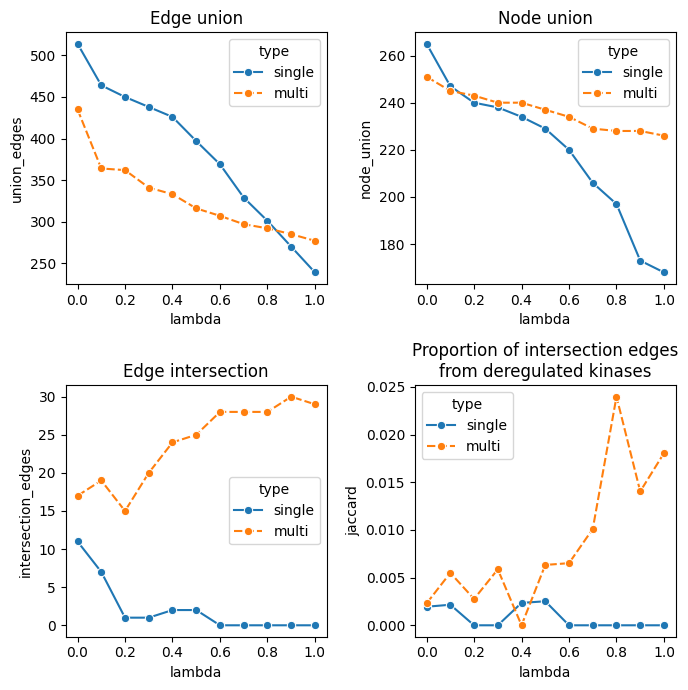

In [32]:
# 2 subplots
results_df = calculate_results(results2, 0)
results_df['jaccard'] = results_df['int_kinases'] / results_df['union_edges']
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
axs = axs.flatten()
sns.lineplot(data = results_df, x = 'lambda', y = 'union_edges', hue = 'type', style = 'type', markers = 'o', ax = axs[0])
axs[0].set_title('Edge union')
sns.lineplot(data = results_df, x = 'lambda', y = 'node_union', hue = 'type', style = 'type', markers = 'o', ax = axs[1])
axs[1].set_title('Node union')
sns.lineplot(data = results_df, x = 'lambda', y = 'intersection_edges', hue = 'type', style = 'type', markers = 'o', ax = axs[2])
axs[2].set_title('Edge intersection')
sns.lineplot(data = results_df, x = 'lambda', y = 'jaccard', hue = 'type', style = 'type', markers = 'o', ax = axs[3])
axs[3].set_title('Proportion of intersection edges\nfrom deregulated kinases')
plt.tight_layout()
plt.show()

# save to svg
fig.savefig('results.svg')

In [44]:
# Aggregate results from multiple seeds
all_results = []
num_seeds = 10
for seed in range(num_seeds):
    df_seed = calculate_results(results2, seed)
    df_seed['jaccard'] = df_seed['int_kinases'] / df_seed['union_edges']
    df_seed['seed'] = seed  # Optional: track the seed
    all_results.append(df_seed)

# Combine all seed data into a single DataFrame
all_results_df = pd.concat(all_results)

{'CDK6', 'ILK', 'CDK2', 'DAPK3', 'CDK7', 'NUAK1', 'PRKDC', 'AKT3', 'GSK3B', 'PAK4', 'TRIB3', 'MAPK3', 'CDK5', 'VRK1', 'NEK9'}
{'CDK6', 'ILK', 'CDK2', 'DAPK3', 'CDK7', 'NUAK1', 'PRKDC', 'AKT3', 'GSK3B', 'PAK4', 'TRIB3', 'MAPK3', 'CDK5', 'VRK1', 'NEK9'}
{'CDK6', 'ILK', 'CDK2', 'DAPK3', 'CDK7', 'NUAK1', 'PRKDC', 'AKT3', 'GSK3B', 'PAK4', 'TRIB3', 'MAPK3', 'CDK5', 'VRK1', 'NEK9'}
{'CDK6', 'ILK', 'CDK2', 'DAPK3', 'CDK7', 'NUAK1', 'PRKDC', 'AKT3', 'GSK3B', 'PAK4', 'TRIB3', 'MAPK3', 'CDK5', 'VRK1', 'NEK9'}
{'CDK6', 'ILK', 'CDK2', 'DAPK3', 'CDK7', 'NUAK1', 'PRKDC', 'AKT3', 'GSK3B', 'PAK4', 'TRIB3', 'MAPK3', 'CDK5', 'VRK1', 'NEK9'}
{'CDK6', 'ILK', 'CDK2', 'DAPK3', 'CDK7', 'NUAK1', 'PRKDC', 'AKT3', 'GSK3B', 'PAK4', 'TRIB3', 'MAPK3', 'CDK5', 'VRK1', 'NEK9'}
{'CDK6', 'ILK', 'CDK2', 'DAPK3', 'CDK7', 'NUAK1', 'PRKDC', 'AKT3', 'GSK3B', 'PAK4', 'TRIB3', 'MAPK3', 'CDK5', 'VRK1', 'NEK9'}
{'CDK6', 'ILK', 'CDK2', 'DAPK3', 'CDK7', 'NUAK1', 'PRKDC', 'AKT3', 'GSK3B', 'PAK4', 'TRIB3', 'MAPK3', 'CDK5', 'VRK1', 

In [45]:
all_results_df

,lambda,type,intersection_edges,union_edges,node_union,int_kinases,jaccard,seed
0,0.0,single,11,514,265,1,0.001946,0
1,0.0,multi,17,435,251,1,0.002299,0
2,0.1,single,7,464,247,1,0.002155,0
3,0.1,multi,19,364,245,2,0.005495,0
4,0.2,single,1,450,240,0,0.000000,0
...,...,...,...,...,...,...,...,...
17,0.8,multi,28,293,226,6,0.020478,9
18,0.9,single,0,262,173,0,0.000000,9
19,0.9,multi,32,286,226,7,0.024476,9
20,1.0,single,0,242,169,0,0.000000,9


In [46]:
all_results_df.to_csv("results.csv")